# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small.

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible.
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files :
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [204]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip
dir_path = "./data/TP4_images/"


In [205]:
! pip install torchmetrics

In [206]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchmetrics.classification import BinaryAccuracy, Accuracy, ConfusionMatrix
# you can install torchmetrics with `pip install torchmetrics`


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

cuda


## Question 1 :
>  Change the last layer of the resnet model so that its size fits the problem.

In [207]:
# Hint
print(base_model)
base_model.fc = nn.Linear(base_model.fc.in_features, 2, bias=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [208]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

In [209]:
from torch.utils.data import Dataset
class OneHotDataset(Dataset):
    def __init__(self, dataset, num_classes=2):
        self.dataset = dataset
        self.num_classes = num_classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        target = torch.nn.functional.one_hot(torch.tensor(target), num_classes=self.num_classes).to(torch.float32)
        return image, target

## Question 2:
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy.

In [210]:
def precompute_features(
    model: models.ResNet,
    dataset: torch.utils.data.Dataset,
    device: torch.device
) -> torch.utils.data.Dataset:
    """
    Create a new dataset with the features precomputed by the model.

    If the model is $f \circ g$ where $f$ is the last layer and $g$ is
    the rest of the model, it is not necessary to recompute $g(x)$ at
    each epoch as $g$ is fixed. Hence you can precompute $g(x)$ and
    create a new dataset
    $\mathcal{X}_{\text{train}}' = \{(g(x_n),y_n)\}_{n\leq N_{\text{train}}}$

    Arguments:
    ----------
    model: models.ResNet
        The model used to precompute the features
    dataset: torch.utils.data.Dataset
        The dataset to precompute the features from
    device: torch.device
        The device to use for the computation

    Returns:
    --------
    torch.utils.data.Dataset
        The new dataset with the features precomputed
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    features_list = []
    labels_list = []

    # Remove the last layer (fc) to get the feature extractor part of the model
    precompute_model = nn.Sequential(*list(model.children())[:-1])
    precompute_model.eval()
    precompute_model.to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            features = precompute_model(X)
            features = features.view(features.size(0), -1)  # Flatten the features
            features_list.append(features.cpu())
            labels_list.append(y.cpu())

    features_tensor = torch.cat(features_list)
    labels_tensor = torch.cat(labels_list)

    new_dataset = torch.utils.data.TensorDataset(features_tensor, labels_tensor)
    return new_dataset

In [211]:
train_dataloader = torch.utils.data.DataLoader(precompute_features(base_model, OneHotDataset(north_dataset), device), batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(precompute_features(base_model, OneHotDataset(test_dataset), device), batch_size=64, shuffle=False)

In [212]:
def train_model(model, lr, criterion, dataloader, epochs=500):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  losses = []
  model.to(device)

  for _ in range(epochs):
    train_loss = 0
    for X, y in dataloader:
      optimizer.zero_grad()
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss = criterion(y_pred, y)
      loss.backward()
      train_loss += loss.item()
      optimizer.step()
    if _ % 100 == 0:
      print(f'Training loss for {_}/{epochs}: {train_loss}')
    losses.append(train_loss)
  return losses

In [213]:
epochs = 100
base_model.fc = nn.Linear(512, 2)
linear_classifier = nn.Linear(base_model.fc.in_features, 2, bias=True).to(device)
losses = train_model(linear_classifier, 1e-3, nn.BCEWithLogitsLoss(weight=torch.Tensor([1., 2.]).to(device)), train_dataloader, epochs)

Training loss for 0/100: 1.0879511833190918


In [214]:
import numpy as np
def eval_model(model, criterion, test_dataloader):
  model.to(device)

  model.eval()
  test_error = 0
  all_preds = []
  all_labels = []
  for X, y in test_dataloader:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X)
    test_error += criterion(y_pred, y).item()
    all_preds.append(y_pred.argmax(dim=1).cpu())

    all_labels.append(y.argmax(dim=1).cpu())
  test_error /= len(test_dataloader)
  print(f'Test error: {test_error}')

  all_preds = torch.cat(all_preds).flatten()
  all_labels = torch.cat(all_labels).flatten()
  cm = ConfusionMatrix(task='binary', num_classes=2)
  confusion_matrix = cm(all_preds, all_labels)
  print(f'Confusion Matrix:\n{confusion_matrix}')

  acc = Accuracy(task="binary", num_classes=2)
  print(f'Accuracy: {acc(all_preds, all_labels)}')


In [215]:
eval_model(base_model.fc, nn.BCEWithLogitsLoss(), test_dataloader)

Test error: 0.7389331459999084
Confusion Matrix:
tensor([[ 0, 21],
        [ 0, 21]])
Accuracy: 0.5


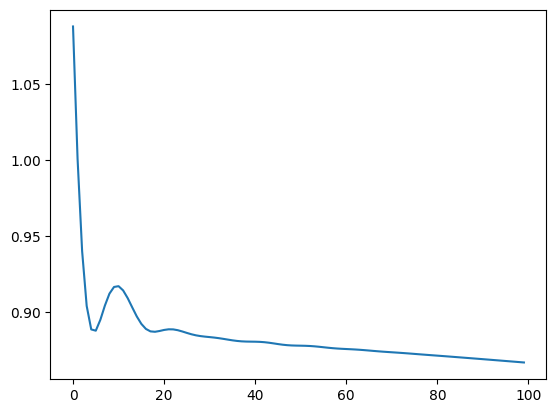

In [216]:
import matplotlib.pyplot as plt
figure = plt.figure()
plt.plot(losses)

<div class="alert alert-info">  Example of answer  </div>

In [217]:
#from utils import precompute_features

## Question 3 :
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve.

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size)

 We will test your model on final accuracy on a test set.


In [218]:
class LastLayer(nn.Module):
    def __init__(self):
        super(LastLayer, self).__init__()
        self.fc1 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        return x

In [219]:
#from utils import LastLayer

resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()  # !  Important : No argument
#fc.load_state_dict(torch.load("lastlayer.pth", weights_only=True))
resnet.fc = fc
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [220]:
train_dataloader = torch.utils.data.DataLoader(precompute_features(resnet, OneHotDataset(north_dataset), device), batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(precompute_features(resnet, OneHotDataset(test_dataset), device), batch_size=64, shuffle=False)
losses = train_model(resnet.fc, 1e-3, nn.BCEWithLogitsLoss(weight=torch.Tensor([1., 2.]).to(device)), train_dataloader, 50)

Training loss for 0/50: 1.0067970752716064


In [221]:
eval_model(resnet.fc.to(device), nn.BCEWithLogitsLoss(), test_dataloader)

Test error: 0.4797995984554291
Confusion Matrix:
tensor([[20,  1],
        [10, 11]])
Accuracy: 0.738095223903656


In [222]:
torch.save(base_model.fc.state_dict(), "lastlayer.pth")

## Question 4 :
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

## Implementation manuelle


In [223]:
import torch
import torch.nn as nn

class LoRAConv(nn.Module):
    def __init__(self, conv_layer, rank, alpha=1.0):
        super(LoRAConv, self).__init__()

        self.conv = conv_layer  # Conserve la convolution d'origine
        self.rank = rank

        # LoRA low-rank decomposition
        self.lora_A = nn.Conv2d(conv_layer.in_channels, rank, kernel_size=conv_layer.kernel_size,
                                stride=conv_layer.stride, padding=conv_layer.padding, bias=False)
        self.lora_B = nn.Conv2d(rank, conv_layer.out_channels, kernel_size=1, stride=1, padding=0, bias=False)


    def forward(self, x):
        return self.conv(x) + self.alpha * self.lora_B(self.lora_A(x))


class LoRAResNet(nn.Module):
    def __init__(self, base_model, rank=4, alpha=4):
        super(LoRAResNet, self).__init__()
        self.base_model = base_model

        # Geler les poids du modèle d'origine
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remplacement des couches convolutives par des LoRAConv
        for name, module in self.base_model.named_modules():
            if isinstance(module, nn.Conv2d) and module.kernel_size != (1, 1):  # Éviter les 1x1 conv
                setattr(self, name, LoRAConv(module, rank, alpha))

    def forward(self, x):
        return self.base_model(x)


## Avec une librairie

In [224]:
!pip install lora_pytorch


In [225]:
from lora_pytorch import LoRA
base_resnet = models.resnet18(weights='DEFAULT')
base_resnet.fc = nn.Linear(base_resnet.fc.in_features, 2, bias=True)
lora_resnet = LoRA.from_module(base_resnet, rank=4)


In [226]:
total_params = sum(p.numel() for p in base_resnet.parameters())
trainable_params = sum(p.numel() for p in lora_resnet.parameters() if p.requires_grad)
percentage = (trainable_params / total_params) * 100
print(f"Total des paramètres : {total_params:,}")
print(f"Paramètres entraînables : {trainable_params:,}")
print(f"Pourcentage de paramètres entraînables : {percentage:.2f}%")


Total des paramètres : 11,323,286
Paramètres entraînables : 145,748
Pourcentage de paramètres entraînables : 1.29%


In [227]:
train_dataloader = torch.utils.data.DataLoader(OneHotDataset(north_dataset), batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(OneHotDataset(test_dataset), batch_size=64, shuffle=False)

In [228]:
losses = train_model(lora_resnet.to(device), 0.001, nn.BCEWithLogitsLoss(), train_dataloader, 50)

Training loss for 0/50: 0.7131887078285217


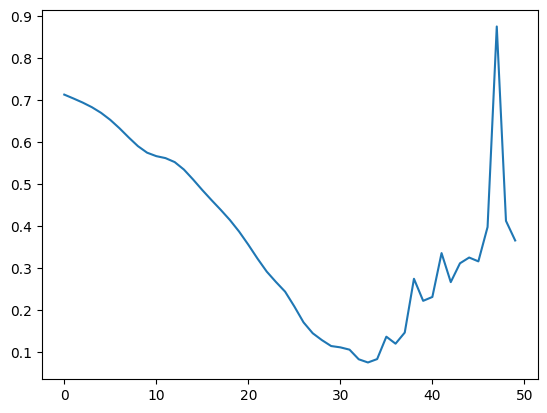

In [229]:
plt.plot(losses)

In [230]:
eval_model(lora_resnet, nn.BCEWithLogitsLoss(), test_dataloader)

Test error: 1.2200056314468384
Confusion Matrix:
tensor([[21,  0],
        [16,  5]])
Accuracy: 0.6190476417541504


In [231]:
torch.save(lora_resnet.state_dict(), "lora_resnet.pth")

## Question 5 :
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`.


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

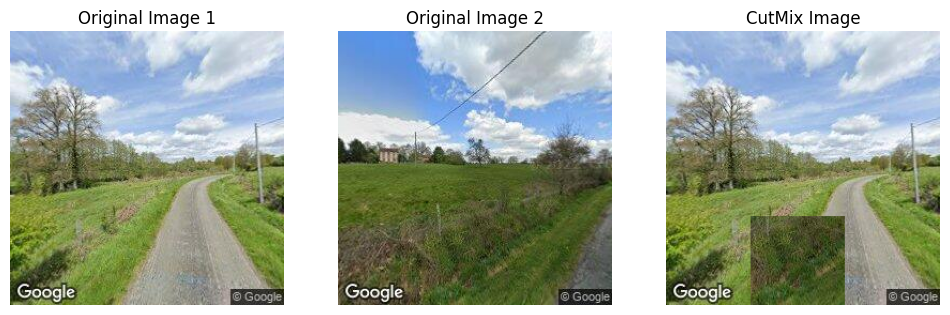

In [193]:
## Data Augmentation
from torchvision import tv_tensors
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define CutMix transform using torchvision v2
cutmix_transform = v2.CutMix(num_classes=2)

# Load two sample images from dataset
image1, target1 = north_dataset[0]
image2, target2 = north_dataset[1]

# Stack images and targets for CutMix
images = torch.stack([image1, image2])
targets = torch.tensor([target1, target2])

# Apply CutMix
cutmix_images, cutmix_targets = cutmix_transform(images, targets)

# Convert image tensor to numpy for visualization
def tensor_to_numpy(image):
    return np.transpose(image.numpy(), (1, 2, 0))

# Visualize the effect of CutMix
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(tensor_to_numpy(image1))
ax[0].set_title("Original Image 1")
ax[1].imshow(tensor_to_numpy(image2))
ax[1].set_title("Original Image 2")
ax[2].imshow(tensor_to_numpy(cutmix_images[0]))
ax[2].set_title("CutMix Image")

for a in ax:
    a.axis("off")
plt.savefig("cutmix.png")
plt.show()



In [195]:
from torchvision.transforms import v2

# Define the data augmentation transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [196]:
from torch.utils.data import ConcatDataset

# Dataset avec transformation standard pour obtenir les images originales
original_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()])
)

# Dataset avec les augmentations définies
augmented_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=data_transforms
)

# Concaténer les deux datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Créer le DataLoader
augmented_train_dataloader = torch.utils.data.DataLoader(OneHotDataset(combined_dataset), batch_size=64, shuffle=True)


In [197]:
#augmented_train_dataloader = torch.utils.data.DataLoader(OneHotDataset(transformed_north_dataset), batch_size=64, shuffle=True)

cutmix = v2.CutMix(num_classes=2)


def train_model(model, lr, criterion, dataloader, epochs=500):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  losses = []
  model.to(device)

  for _ in range(epochs):
    train_loss = 0
    for X, y in dataloader:
      optimizer.zero_grad()
      X = X.to(device)
      y = y.to(device)
      X, y = cutmix(X, y)
      y_pred = model(X)
      loss = criterion(y_pred, y)
      loss.backward()
      train_loss += loss.item()
      optimizer.step()
    if _ % 100 == 0:
      print(f'Training loss for {_}/{epochs}: {train_loss}')
    losses.append(train_loss)
  return losses



In [200]:
#lora_model = NotImplementedError  # <YOUR CODE>
base_resnet = models.resnet18(weights='DEFAULT')
base_resnet.fc = nn.Linear(base_resnet.fc.in_features, 2, bias=True)
lora_model = LoRA.from_module(base_resnet, rank=4)
assert isinstance(lora_model.module, models.ResNet)

In [201]:
torch.save(lora_model.state_dict(), "daug_resnet.pth")

In [233]:
losses = train_model(lora_model.to(device), 0.001, nn.BCEWithLogitsLoss(), augmented_train_dataloader, 50)

Training loss for 0/50: 1.287666141986847


In [234]:
eval_model(lora_model, nn.BCEWithLogitsLoss(), test_dataloader)

Test error: 0.6831141114234924
Confusion Matrix:
tensor([[21,  0],
        [ 6, 15]])
Accuracy: 0.8571428656578064


## Question 6 : (BONUS)
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file.

In [248]:
base_resnet = models.resnet18(weights='DEFAULT')
base_resnet.fc = nn.Linear(base_resnet.fc.in_features, 2, bias=True)
lora_model = LoRA.from_module(base_resnet, rank=4)
assert isinstance(lora_model.module, models.ResNet)

In [249]:
torch.save(lora_model.state_dict(), "final_model.pth")

In [250]:
losses = train_model(lora_model.to(device), 0.001, nn.BCEWithLogitsLoss(), augmented_train_dataloader, 100)

Training loss for 0/100: 1.41591876745224


In [251]:
eval_model(lora_model, nn.BCEWithLogitsLoss(), test_dataloader)

Test error: 0.5534597635269165
Confusion Matrix:
tensor([[20,  1],
        [ 4, 17]])
Accuracy: 0.8809523582458496
